In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
import geopandas as gpd
import xarray as xr
import rioxarray
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import matplotlib as mpl
import cartopy.feature as cf
import regionmask


In [2]:
shp_pan = gpd.read_file(r'Data\shapefiles\panamz.geojson')
folder_metric = r'Data\Datasets\amz\map'
datasets = ['cru', 'gpcc', 'chirps','imerg', 'terra', 'era_land', 'jra55','merra2']
datasets_names = ['CRU', 'GPCC', 'CHIRPS','IMERG-V6', 'TerraClimate', 'ERA5-Land', 'JRA55','MERRA2']
stations = gpd.read_file(r'Data\Datasets\amz\map\stations.geojson')
regions = gpd.read_file(r'Data\shapefiles\ANA_amz.geojson', driver='GeoJSON')
regions_mask = regionmask.from_geopandas(regions, names='Region')

In [3]:
from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 18})
regions_list = ['Western', 'Northern', 'Southern', 'Eastern']
regions_replace = { 0:'Southern', 1:'Eastern',2:'Western', 3:'Northern'}
letters_22 = ['j)', 'k)', 'l)', 'm)']
letters_22_eva = ['i)','j)', 'k)', 'l)']

wong = ['#882255','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7','#999999']
wong_b = ['#882255','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7','#000000']
hue_order = datasets_names.copy()
hue_order.append('Stations')
legend_elements = [Line2D([0], [0],  marker='s', color='w', label=hue_order[i], markerfacecolor=wong[i], markersize=12) for i in range(len(wong))]
legend_elements_b = [Line2D([0], [0],  marker='s', color='w', label=hue_order[i], markerfacecolor=wong_b[i], markersize=12) for i in range(len(wong_b))]


In [4]:
ds_dict = {}
for i, dataset in enumerate(datasets):
    ds = xr.open_dataset(os.path.join(folder_metric, dataset + '.nc'))
    #create mask from regions
    mask = regions_mask.mask(ds, lon_name='lon', lat_name='lat')
    ds['Region'] = mask
    ds_dict[datasets_names[i]] = ds
    

c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry
c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry


# pixel

In [3]:
df_stat = pd.read_csv(r'Data\Datasets\amz\map\stations_ts.csv', index_col=0)
#merge with stations to get the region
df_stat = df_stat.merge(stations[['Code','geometry']], on='Code')
df_stat = df_stat.rename(columns={'Total':'pr', 'Date':'year'})
# Step 1: Convert GeoDataFrame to DataFrame with point coordinates, rainfall values, and timestamps
data = df_stat[['geometry', 'year', 'pr']].copy()
data['lon'] = data['geometry'].apply(lambda p: p.x)
data['lat'] = data['geometry'].apply(lambda p: p.y)
data = data.drop(columns=['geometry'])
var = 'pr'

In [6]:
pixel_dict = {}

for name in datasets_names:
    ds = ds_dict[name].copy()

    # Step 2: Assign each point to the grid cells of the 'ds' DataArray
    ds_grid_lon, ds_grid_lat = ds.lon.values, ds.lat.values

    data['lon_bin'] = np.digitize(data['lon'], ds_grid_lon)
    data['lat_bin'] = np.digitize(data['lat'], ds_grid_lat)

    # Step 3: Compute the mean value for each grid cell and each year
    grid_cells = data.groupby(['year', 'lat_bin', 'lon_bin'])[var].mean().reset_index()

    # Step 4: Create an empty DataArray with NaN values
    empty_grid = np.full((len(data['year'].unique()), len(ds_grid_lat), len(ds_grid_lon)), np.nan)

    # Step 5: Fill the DataArray with the computed mean values for each year
    for _, row in grid_cells.iterrows():
        year_idx = np.where(data['year'].unique() == row['year'])[0][0]
        lat_idx, lon_idx = row['lat_bin'], row['lon_bin']
        lat_idx, lon_idx = int(lat_idx), int(lon_idx)

        empty_grid[year_idx, lat_idx - 1, lon_idx - 1] = row[var]

    # Step 6: Create an xarray DataArray from the result with the year dimension
    year_coords = data['year'].unique()
    data_array = xr.DataArray(empty_grid,
                                dims=('year', 'lat', 'lon'),
                                coords={'year': year_coords, 'lat': ds_grid_lat, 'lon': ds_grid_lon})



    data_array = data_array.to_dataset(name=var)
    data_array['Region'] = ds['Region']
    pixel_dict[name] = ds.where(data_array.pr >= 0)


In [7]:
df = pd.DataFrame()
for name in datasets_names:
    ds = pixel_dict[name]
    dff =  ds.to_dataframe().dropna().reset_index()
    dff['Dataset'] = name
    df = df.append(dff)
df = df[['year','pr', 'Region', 'Dataset']]
df['Region'] = df['Region'].replace(regions_replace)
df_stat = pd.read_csv(r'Data\Datasets\amz\map\stations_ts.csv', index_col=0)
#merge with stations to get the region
df_stat = df_stat.merge(stations[['Code', 'Region']], on='Code')
df_stat = df_stat.rename(columns={'Total':'pr', 'Date':'year'})
df_stat['Dataset'] = 'Stations'
df_stat = df_stat[['year', 'pr','Region', 'Dataset']]
df = df.append(df_stat)


C:\Users\luisg\AppData\Local\Temp\ipykernel_18708\2031244993.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_18708\2031244993.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_18708\2031244993.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_18708\2031244993.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_18708\2031244993.py:6: FutureWarning: The frame.append method is dep

In [32]:
import scipy.stats as stats

ndatasets=len(datasets_names)+1
#bins for histograms
bins=10*np.arange(500)
#What is going on here?  Test!
bin_centers=bins[0:-1]+np.diff(bins)/2.
nbins=len(bins)
df_pdf = pd.DataFrame()
for i, name in enumerate(['CRU', 'GPCC', 'CHIRPS', 'IMERG-V6', 'TerraClimate', 'ERA5-Land','JRA55', 'MERRA2', 'Stations']):
    df_ds = df[df.Dataset == name]
    for j, region in enumerate(['Western', 'Northern', 'Southern', 'Eastern']):
        df_region = df_ds[df_ds.Region == region]
        fit_alpha, fit_loc, fit_beta = stats.genextreme.fit(df_region['pr'].values)
        #tranform the data to a genextreme function
        genextreme = stats.genextreme.pdf(bin_centers, fit_alpha, fit_loc, fit_beta)
        histt = np.histogram(df_region['pr'], bins=bins, density=True)[0]
        df_pdf = df_pdf.append(pd.DataFrame({'Dataset': name, 'Region': region, 'hist': histt, 'Bin': bin_centers, 'genextreme':genextreme}))

C:\Users\luisg\AppData\Local\Temp\ipykernel_19920\3893978221.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_pdf = df_pdf.append(pd.DataFrame({'Dataset': name, 'Region': region, 'hist': histt, 'Bin': bin_centers, 'genextreme':genextreme}))
C:\Users\luisg\AppData\Local\Temp\ipykernel_19920\3893978221.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_pdf = df_pdf.append(pd.DataFrame({'Dataset': name, 'Region': region, 'hist': histt, 'Bin': bin_centers, 'genextreme':genextreme}))
C:\Users\luisg\AppData\Local\Temp\ipykernel_19920\3893978221.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_pdf = df_pdf.append(pd.DataFrame({'Dataset': name, 'Region': region, 'hist': histt, 'Bin': bin_centers, 'genextreme':gen

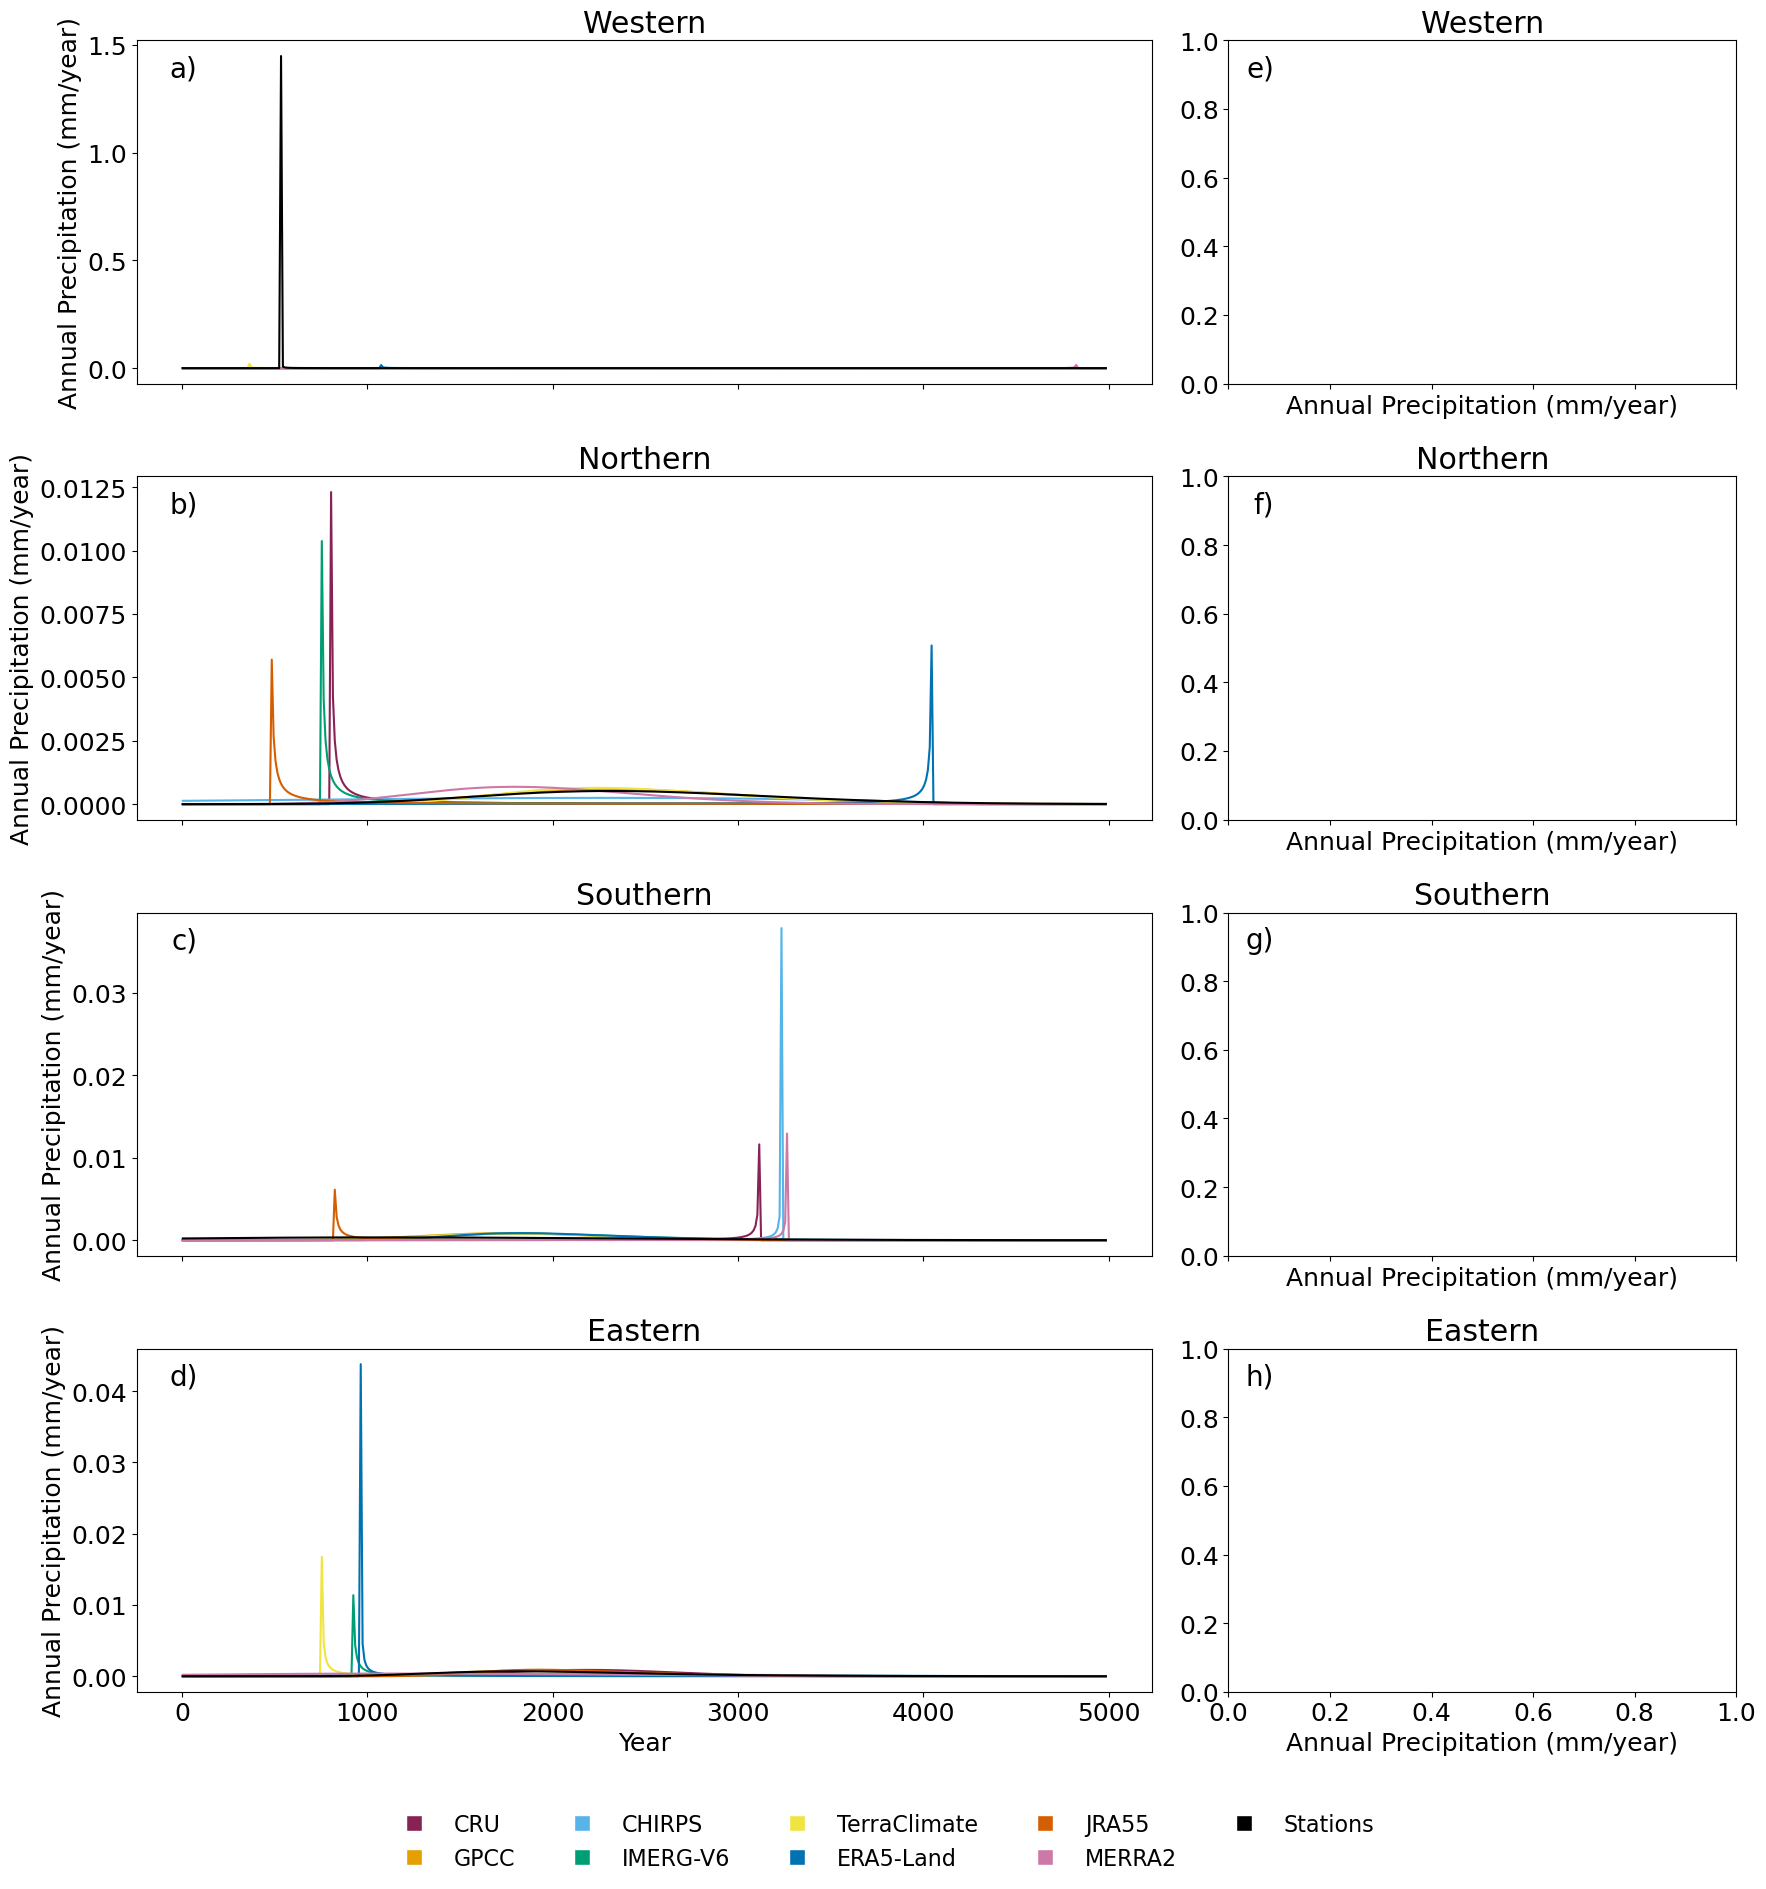

In [35]:
fig, axs = plt.subplots(4, 2, figsize=(18, 18), gridspec_kw={'width_ratios': [2, 1]}, sharex='col')
plt.rcParams.update({'font.size': 18})
letters_ts = ['a)', 'b)', 'c)', 'd)']
letters_pdf = ['e)', 'f)', 'g)', 'h)']
for i, region in enumerate(regions_list):
    df_reg = df_pdf[df_pdf['Region'] == region]
    sns.lineplot(data=df_reg, ax=axs[i, 0], x='Bin', y='genextreme', hue='Dataset', palette=wong_b, hue_order=hue_order, legend=False)
    #sns.kdeplot(data=df_pdf, ax=axs[i, 1], x='pr', hue='Dataset', fill=False, common_norm=False, linewidth=2,palette=wong_b, hue_order=hue_order, legend=False)
    #sns.kdeplot(data=df_pdf[df_pdf.Dataset=='Stations'], x='pr', fill=False,linewidth=2,color='black', zorder=100,ax=axs[i, 1], legend=False) 
    axs[i, 0].set_title(region)
    axs[i, 1].set_title(region)
    axs[i, 0].set_ylabel('Annual Precipitation (mm/year)')
    axs[i, 0].set_xlabel('Year')
    axs[i, 1].set_xlabel('Annual Precipitation (mm/year)')
    #axs[i, 1].set_xlim(0, 6000)
    #axs[i, 0].set_xticks([2001, 2005,2010, 2015, 2020])
    axs[i, 0].text(0.06,0.96,  letters_ts[i], transform=axs[i, 0].transAxes,  fontsize=20, va='top', ha='right')
    axs[i, 1].text(0.09,0.96,  letters_pdf[i], transform=axs[i, 1].transAxes,  fontsize=20, va='top', ha='right')   
    #Set axs[i, 1] y-axis as scientific notation
    axs[i, 1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#create legend in the bottom center of the figure
fig.legend(handles=legend_elements_b, bbox_to_anchor=(0.5, -0.06), loc='lower center', ncol=5, frameon=False, fontsize=16)


plt.tight_layout()

# TSSS

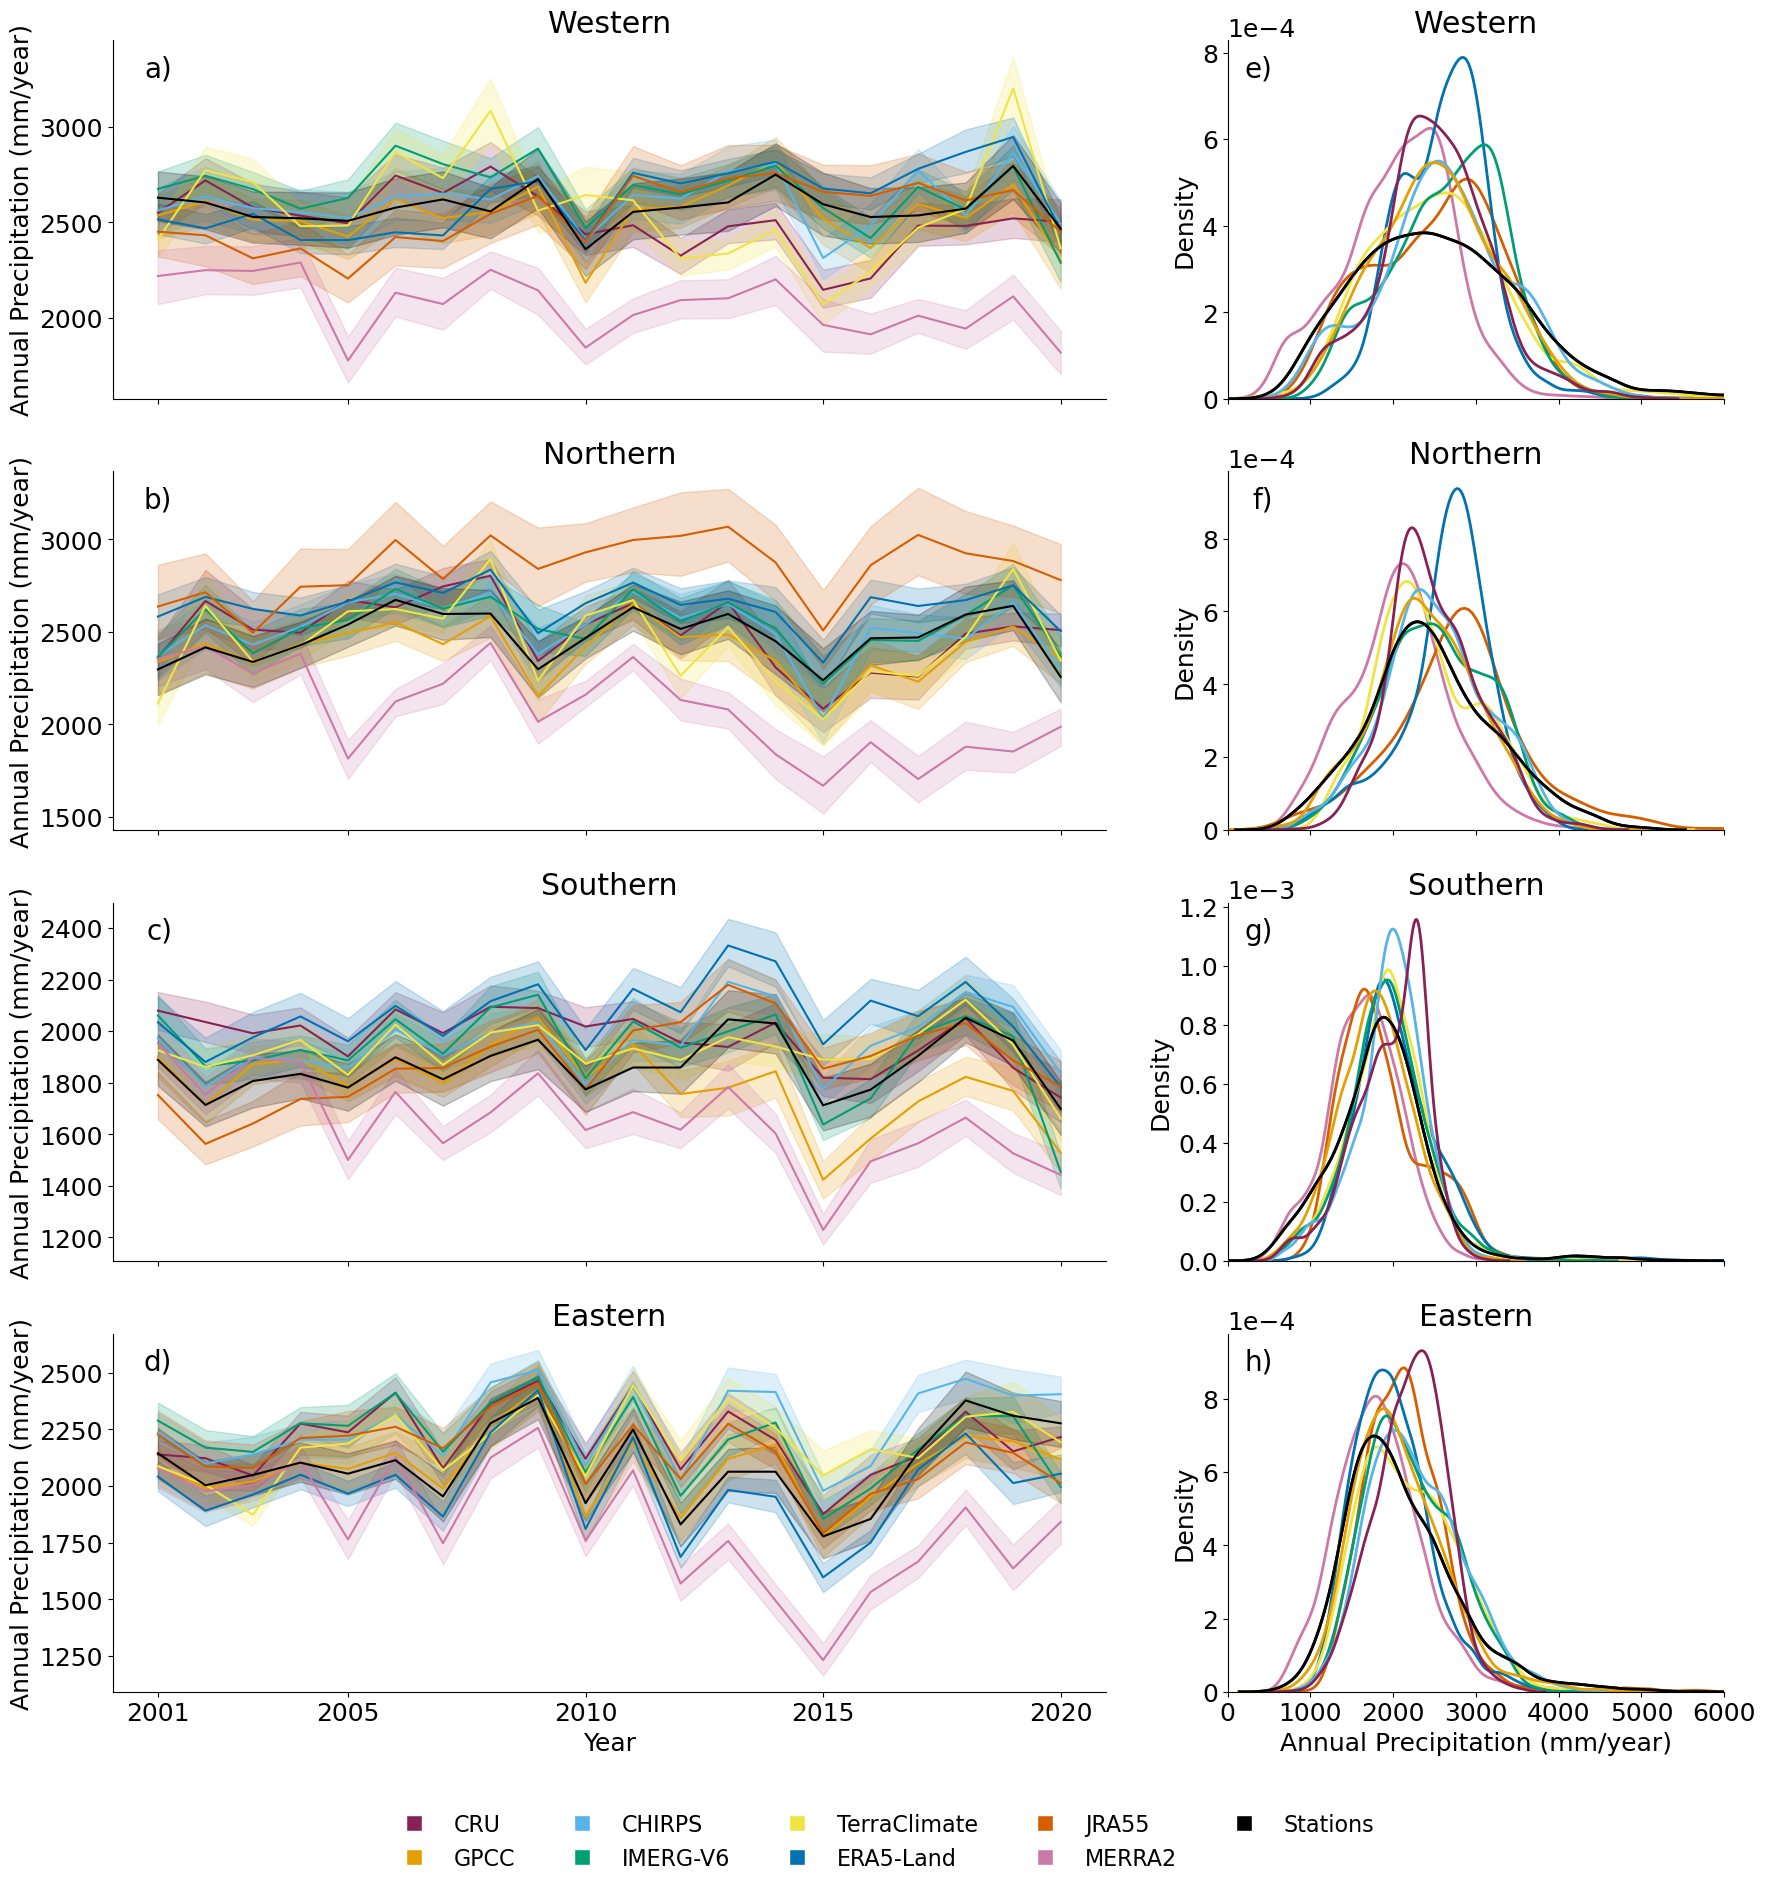

In [8]:
fig, axs = plt.subplots(4, 2, figsize=(18, 18), gridspec_kw={'width_ratios': [2, 1]}, sharex='col')
plt.rcParams.update({'font.size': 18})
letters_ts = ['a)', 'b)', 'c)', 'd)']
letters_pdf = ['e)', 'f)', 'g)', 'h)']
for i, region in enumerate(regions_list):
    df_region = df[df['Region'] == region]
    sns.lineplot(data=df_region, ax=axs[i, 0], x='year', y='pr', hue='Dataset', palette=wong_b, hue_order=hue_order, legend=False)
    sns.kdeplot(data=df_region, ax=axs[i, 1], x='pr', hue='Dataset', fill=False, common_norm=False, linewidth=2,palette=wong_b, hue_order=hue_order, legend=False)
    sns.kdeplot(data=df_region[df_region.Dataset=='Stations'], x='pr', fill=False,linewidth=2,color='black', zorder=100,ax=axs[i, 1], legend=False) 
    axs[i, 0].set_title(region)
    axs[i, 1].set_title(region)
    axs[i, 0].set_ylabel('Annual Precipitation (mm/year)')
    axs[i, 0].set_xlabel('Year')
    axs[i, 1].set_xlabel('Annual Precipitation (mm/year)')
    axs[i, 1].set_xlim(0, 6000)
    axs[i, 0].set_xticks([2001, 2005,2010, 2015, 2020])
    axs[i, 0].text(0.06,0.96,  letters_ts[i], transform=axs[i, 0].transAxes,  fontsize=20, va='top', ha='right')
    axs[i, 1].text(0.09,0.96,  letters_pdf[i], transform=axs[i, 1].transAxes,  fontsize=20, va='top', ha='right')   
    #Set axs[i, 1] y-axis as scientific notation
    axs[i, 1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    #DESPINE
    sns.despine(ax=axs[i, 0], top=True, right=True, left=False, bottom=False)
    sns.despine(ax=axs[i, 1], top=True, right=True, left=False, bottom=False)
#create legend in the bottom center of the figure
fig.legend(handles=legend_elements_b, bbox_to_anchor=(0.5, -0.06), loc='lower center', ncol=5, frameon=False, fontsize=16)


plt.tight_layout()

## taylor

In [9]:
from Data.utils.taylor import *
from scipy.stats import pearsonr
df_mean = df.groupby(['year', 'Region', 'Dataset']).mean().reset_index()
#for each dataset and each region, do the pearson r with stations
df_corr = pd.DataFrame()
std_ref = []
for region in regions_list:
    df_region = df_mean[df_mean['Region'] == region]
    df_station = df_region[df_region['Dataset'] == 'Stations']
    for dataset in datasets_names:
        df_ds = df_region[df_region['Dataset'] == dataset]
        # do correlation
        corr = pearsonr(df_ds.pr.values, df_station.pr.values)[0].round(2)
        df_corr = df_corr.append({'Region': region, 'Dataset': dataset, 'corr': corr, 'sd':df_ds.pr.values.std()/df_station.pr.values.std()}, ignore_index=True)
        std_ref.append(df_station.pr.values.std())
        

C:\Users\luisg\AppData\Local\Temp\ipykernel_18708\1594821198.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr = df_corr.append({'Region': region, 'Dataset': dataset, 'corr': corr, 'sd':df_ds.pr.values.std()/df_station.pr.values.std()}, ignore_index=True)
C:\Users\luisg\AppData\Local\Temp\ipykernel_18708\1594821198.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr = df_corr.append({'Region': region, 'Dataset': dataset, 'corr': corr, 'sd':df_ds.pr.values.std()/df_station.pr.values.std()}, ignore_index=True)
C:\Users\luisg\AppData\Local\Temp\ipykernel_18708\1594821198.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr = df_corr.append({'Region': region, 'Dataset': dataset, 'corr': corr, 'sd':df

In [10]:
df_corr

Region       Dataset  corr        sd
0    Western           CRU  0.17  1.640389
1    Western          GPCC  0.86  1.481184
2    Western        CHIRPS  0.69  1.391746
3    Western      IMERG-V6  0.68  1.561433
4    Western  TerraClimate  0.25  2.808881
5    Western     ERA5-Land  0.59  1.760702
6    Western         JRA55  0.47  1.656828
7    Western        MERRA2  0.49  1.583693
8   Northern           CRU  0.63  1.356510
9   Northern          GPCC  0.80  1.076524
10  Northern        CHIRPS  0.88  1.223910
11  Northern      IMERG-V6  0.89  1.046056
12  Northern  TerraClimate  0.75  1.724625
13  Northern     ERA5-Land  0.86  0.824524
14  Northern         JRA55  0.70  1.230829
15  Northern        MERRA2  0.11  1.805422
16  Southern           CRU  0.44  0.945666
17  Southern          GPCC  0.54  1.366278
18  Southern        CHIRPS  0.96  1.121147
19  Southern      IMERG-V6  0.78  1.534884
20  Southern  TerraClimate  0.76  0.857874
21  Southern     ERA5-Land  0.85  1.220631
22  Southern         JRA55  0.74  1.445548
23  Southern        MERRA2  0.36  1.616405
24   Eastern           CRU  0.74  0.861947
25   Eastern          GPCC  0.91  0.858217
26   Eastern        CHIRPS  0.89  0.956261
27   Eastern      IMERG-V6  0.75  0.937748
28   Eastern  TerraClimate  0.61  0.831450
29   Eastern     ERA5-Land  0.93  1.113516
30   Eastern         JRA55  0.68  0.847004
31   Eastern        MERRA2  0.63  1.485512

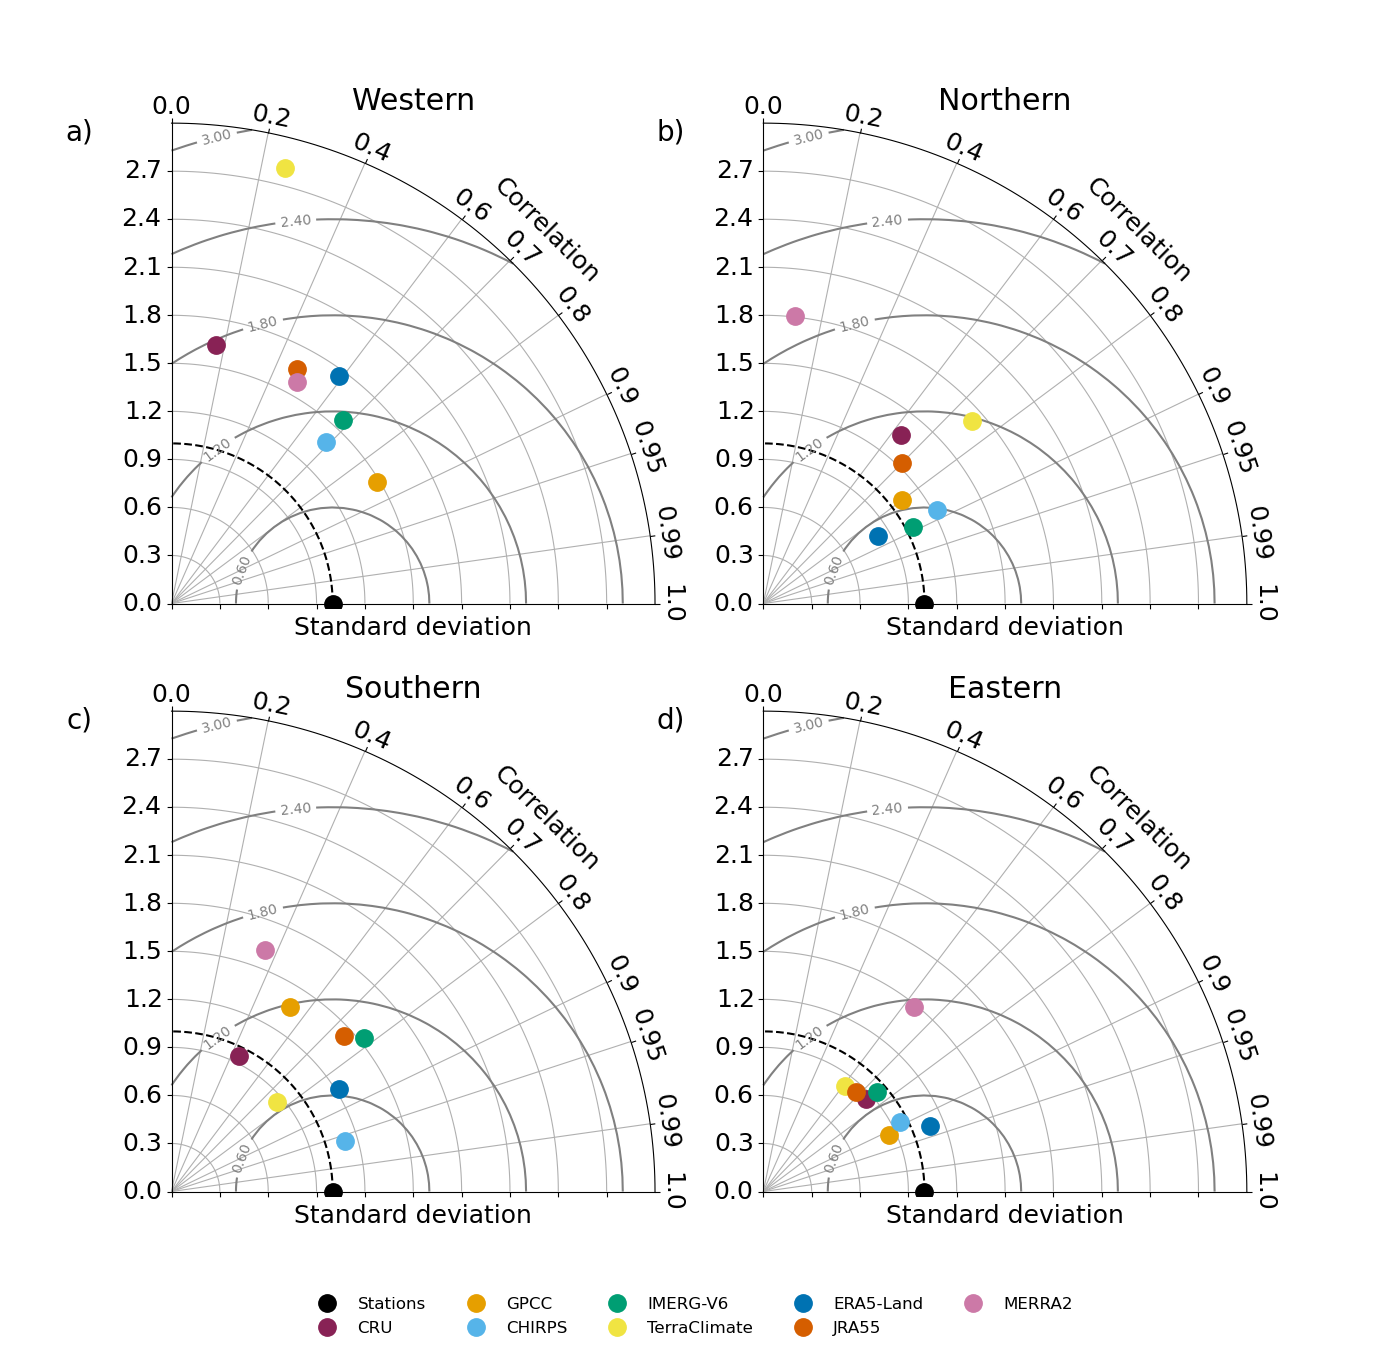

In [11]:
# Create a figure and a gridspec layout
fig = plt.figure(figsize=(14, 14))
letters_ts = ['a)', 'b)', 'c)', 'd)']

mss = 25
for i, region in enumerate(regions_list ):
    dia = TaylorDiagram(1, fig=fig, label='Stations', extend=False, rect=int('22'+str(i+1)),srange=(0, 3),mss =mss)
# Create a figure and a gridspec layout

    df_reg = df_corr[df_corr.Region == region]
    # Add samples to Taylor diagram
    contours = dia.add_contours(colors='0.5')
    for j, name in enumerate(datasets_names):
        df_set = df_reg[df_reg['Dataset'] == name]
        std = df_set['sd'].values[0]
        corr = df_set['corr'].values[0]
        dia.add_sample(std, corr, marker='.', ms=mss, ls='', mfc=wong_b[j], mec=wong_b[j], label=name)
    dia.add_grid()                                  # Add grid
    dia._ax.axis[:].major_ticks.set_tick_out(True)
    dia._ax.axis['left'].toggle(ticklabels=False)
    dia._ax.axis['left'].label.set_text("Standard deviation")
    dia._ax.set_title(region)
    dia._ax.text(-0.15,1,  letters_ts[i], transform=dia._ax.transAxes,  fontsize=20, va='top', ha='right')    
    # Put ticks outward
#legend in the middle outside of the plot
    plt.clabel(contours, inline=1, fontsize=10, fmt='%.2f')

fig.legend(dia.samplePoints,
               [ p.get_label() for p in dia.samplePoints ],
               numpoints=1, bbox_to_anchor=(0.5, 0.0), loc='lower center', ncol=5, frameon=False, fontsize=12)

#legend in the middle outside of the plot
plt.tight_layout()

# point to pixel

In [5]:
df_stat = pd.read_csv(r'Data\Datasets\amz\map\stations_ts.csv', index_col=0)
#merge with stations to get the region
df_stat = df_stat.merge(stations[['Code','geometry']], on='Code')
df_stat = df_stat.rename(columns={'Total':'pr', 'Date':'year'})
# Step 1: Convert GeoDataFrame to DataFrame with point coordinates, rainfall values, and timestamps
data = df_stat[['geometry', 'year', 'pr']].copy()
data['lon'] = data['geometry'].apply(lambda p: p.x)
data['lat'] = data['geometry'].apply(lambda p: p.y)
data = data.drop(columns=['geometry'])


In [6]:
from Data.utils.evaluation import calculate_metrics, create_metrics_dataframe,  datasets_05
from Data.utils.datasets_plotting import plot_datasets33_nostat
metrics_dict = calculate_metrics(data, datasets_names, ds_dict, 'pr')
df_metrics = create_metrics_dataframe(metrics_dict, datasets_names)
metrics_dict_05 = datasets_05(metrics_dict, ds_dict, datasets_names)

d:\GU\IC\Scripts\Data\utils\evaluation.py:151: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append(dff)
d:\GU\IC\Scripts\Data\utils\evaluation.py:151: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append(dff)
d:\GU\IC\Scripts\Data\utils\evaluation.py:151: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append(dff)
d:\GU\IC\Scripts\Data\utils\evaluation.py:151: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append(dff)
d:\GU\IC\Scripts\Data\utils\evaluation.py:151: FutureWarning: The frame.append method is deprecated and will be removed from pan

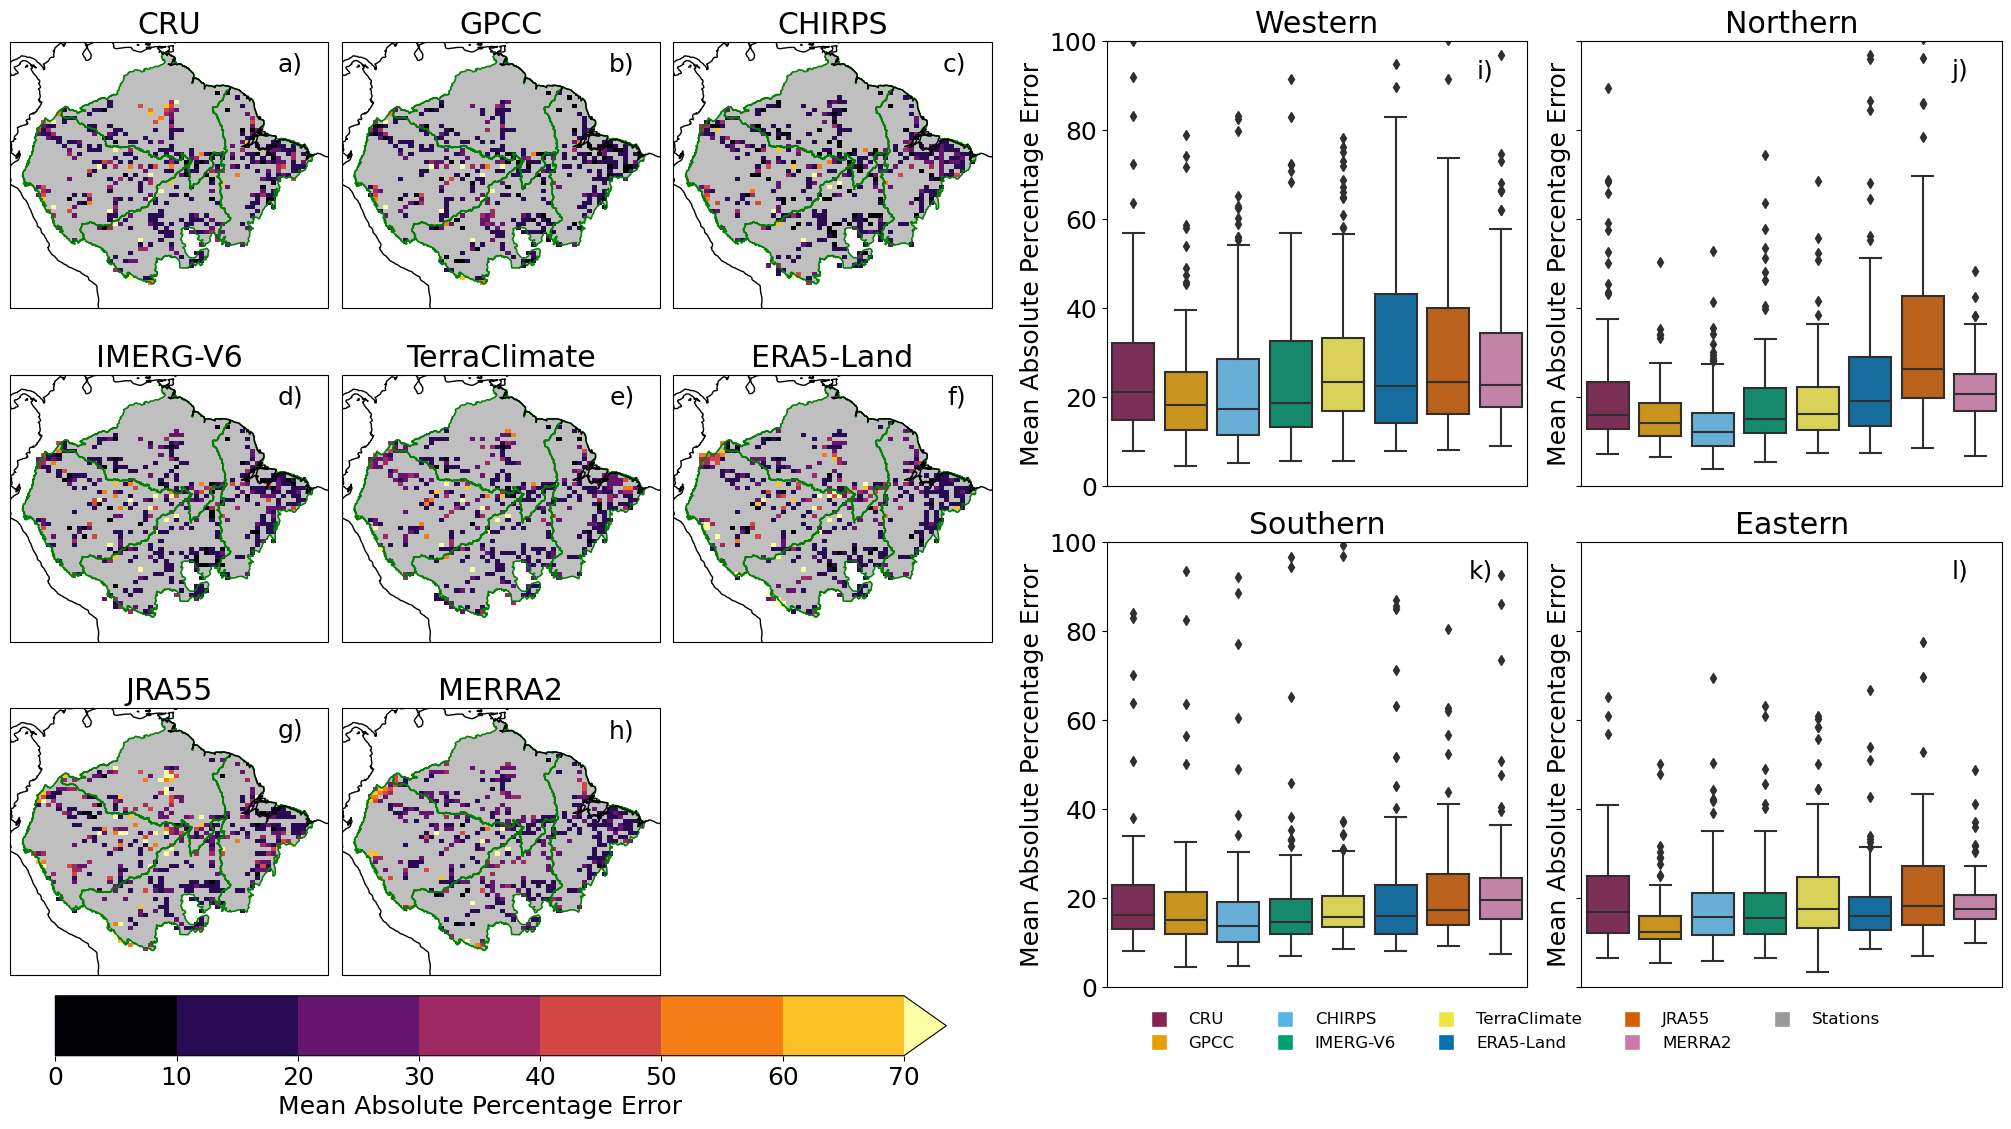

In [8]:
vmin = 0
vmax = 70
levels = 8
cmap =  mpl.cm.inferno
extend_cbar = 'max'
var = 'mape'
var_stat = 'Total'
label_cbar = 'Mean Absolute Percentage Error'
letters_22_eva = ['i)','j)', 'k)', 'l)']
fig = plt.figure(layout='constrained', figsize=(20, 10))
subfigs = fig.subfigures(1, 2)
axs_right = subfigs[1].subplots(2, 2, sharex=True, sharey=True)
axs_right = axs_right.flatten()
for i, region in enumerate(regions_list):
    #boxplot of df_metrics
    sns.boxplot( y=var, data=df_metrics[df_metrics.Region==region], ax=axs_right[i], hue_order=hue_order, palette=wong, hue='Dataset',x='Dataset',dodge=False).get_legend().remove()
    axs_right[i].set_title(region)
    axs_right[i].set_xlabel('')
    axs_right[i].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) 
    axs_right[i].set_ylabel(label_cbar)
    axs_right[i].set_ylim([vmin, 100])
    axs_right[i].text(0.92,0.96,  letters_22_eva[i], transform=axs_right[i].transAxes,  fontsize=18, va='top', ha='right')
#create legend in the bottom center of the figure
subfigs[1].legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.06), loc='lower center', ncol=5, frameon=False, fontsize=12)
plot_datasets33_nostat(subfigs[0], datasets_names, metrics_dict_05,  regions, vmin, vmax, levels, cmap, extend_cbar, var, var_stat, label_cbar)


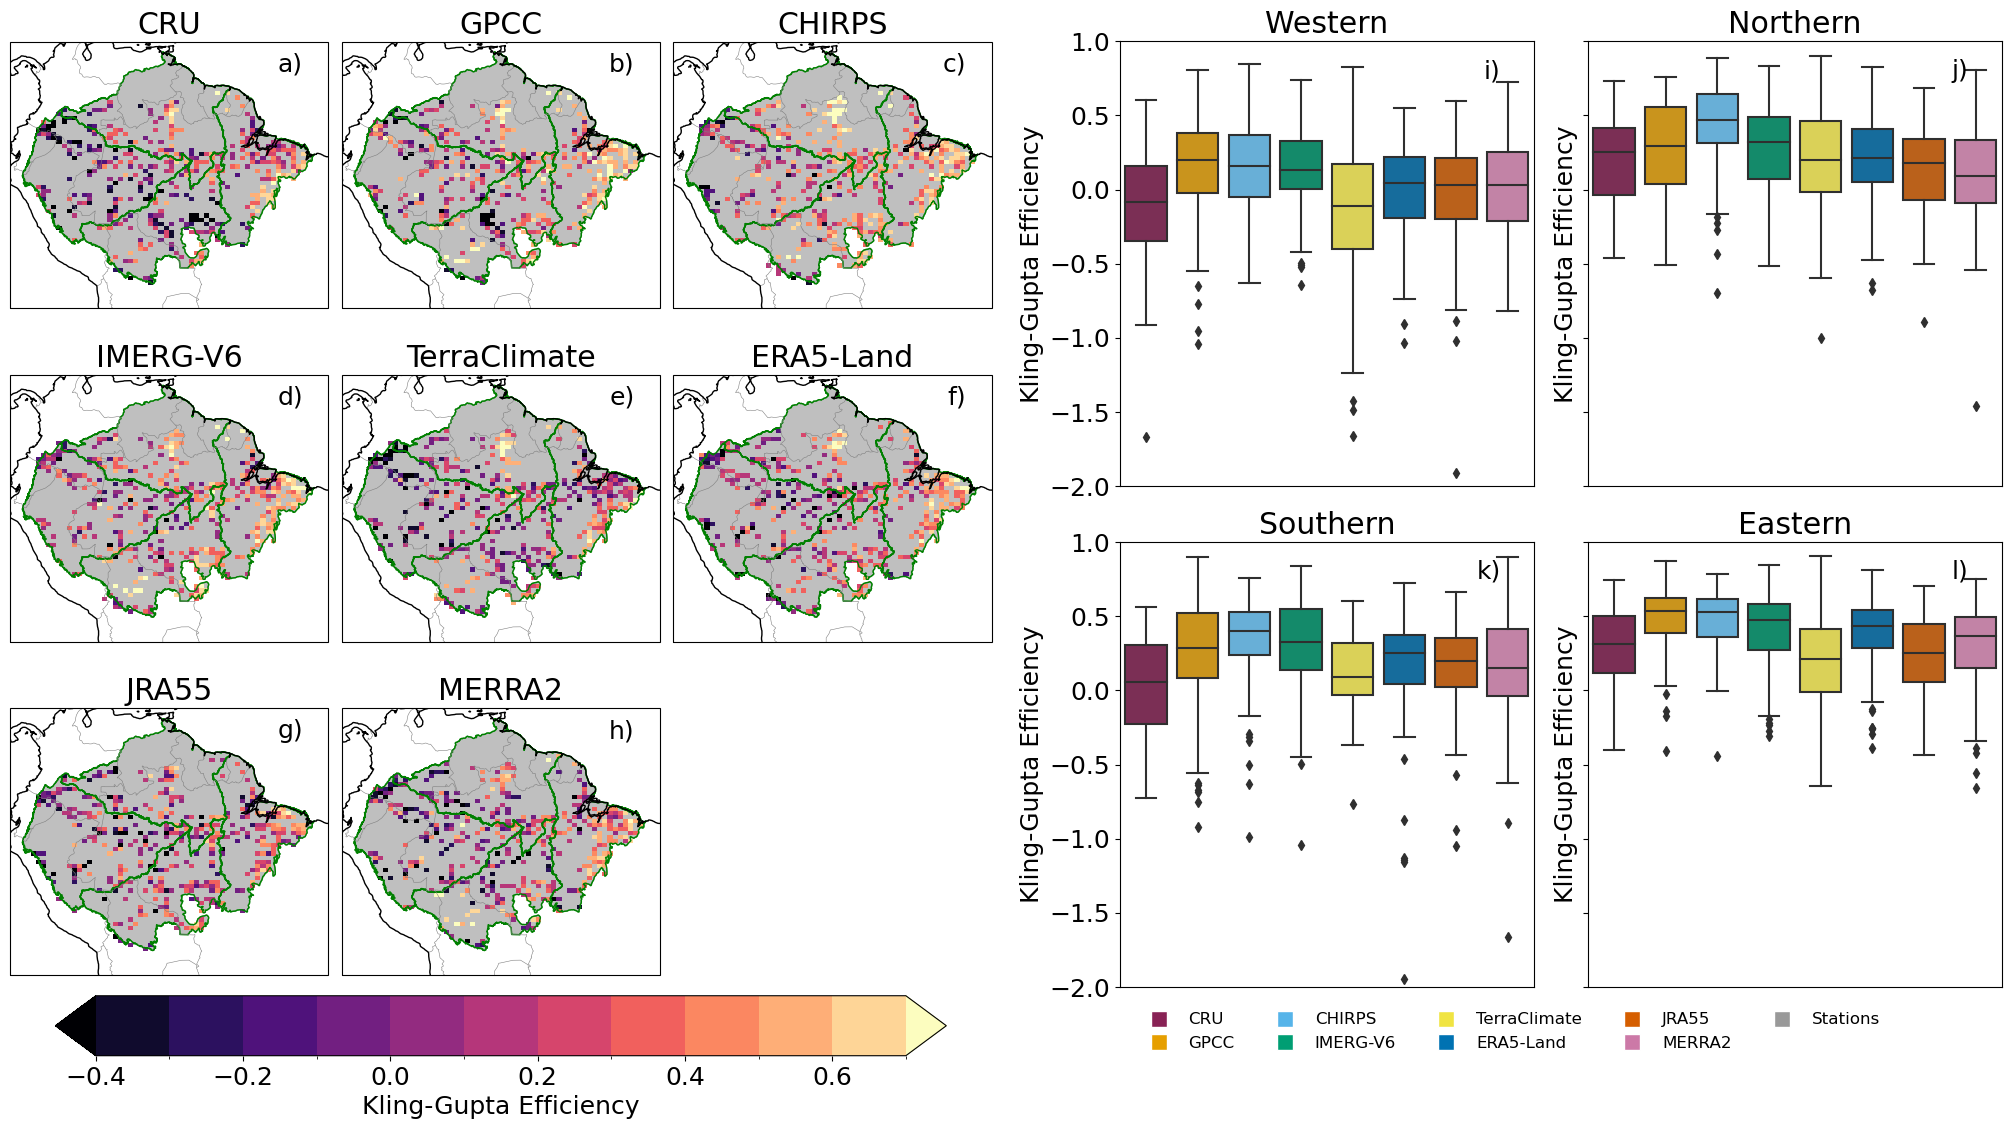

In [18]:
vmin = -0.4
vmax = 0.7
levels = 12
cmap =  mpl.cm.magma
extend_cbar = 'both'
var = 'kge'
var_stat = 'kge'
label_cbar = 'Kling-Gupta Efficiency'
fig = plt.figure(layout='constrained', figsize=(20, 10))
subfigs = fig.subfigures(1, 2)
axs_right = subfigs[1].subplots(2, 2, sharex=True, sharey=True)
axs_right = axs_right.flatten()
for i, region in enumerate(regions_list):
    #boxplot of df_metrics
    sns.boxplot( y=var, data=df_metrics[df_metrics.Region==region], ax=axs_right[i], hue_order=hue_order, palette=wong, hue='Dataset',x='Dataset',dodge=False).get_legend().remove()
    axs_right[i].set_title(region)
    axs_right[i].set_xlabel('')
    axs_right[i].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) 
    axs_right[i].set_ylabel(label_cbar)
    axs_right[i].set_ylim([-2, 1])
    axs_right[i].text(0.92,0.96,  letters_22_eva[i], transform=axs_right[i].transAxes,  fontsize=18, va='top', ha='right')
    
#create legend in the bottom center of the figure
subfigs[1].legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.06), loc='lower center', ncol=5, frameon=False, fontsize=12)
plot_datasets33_nostat(subfigs[0], datasets_names, metrics_dict_05,  regions, vmin, vmax, levels, cmap, extend_cbar, var, var_stat, label_cbar)


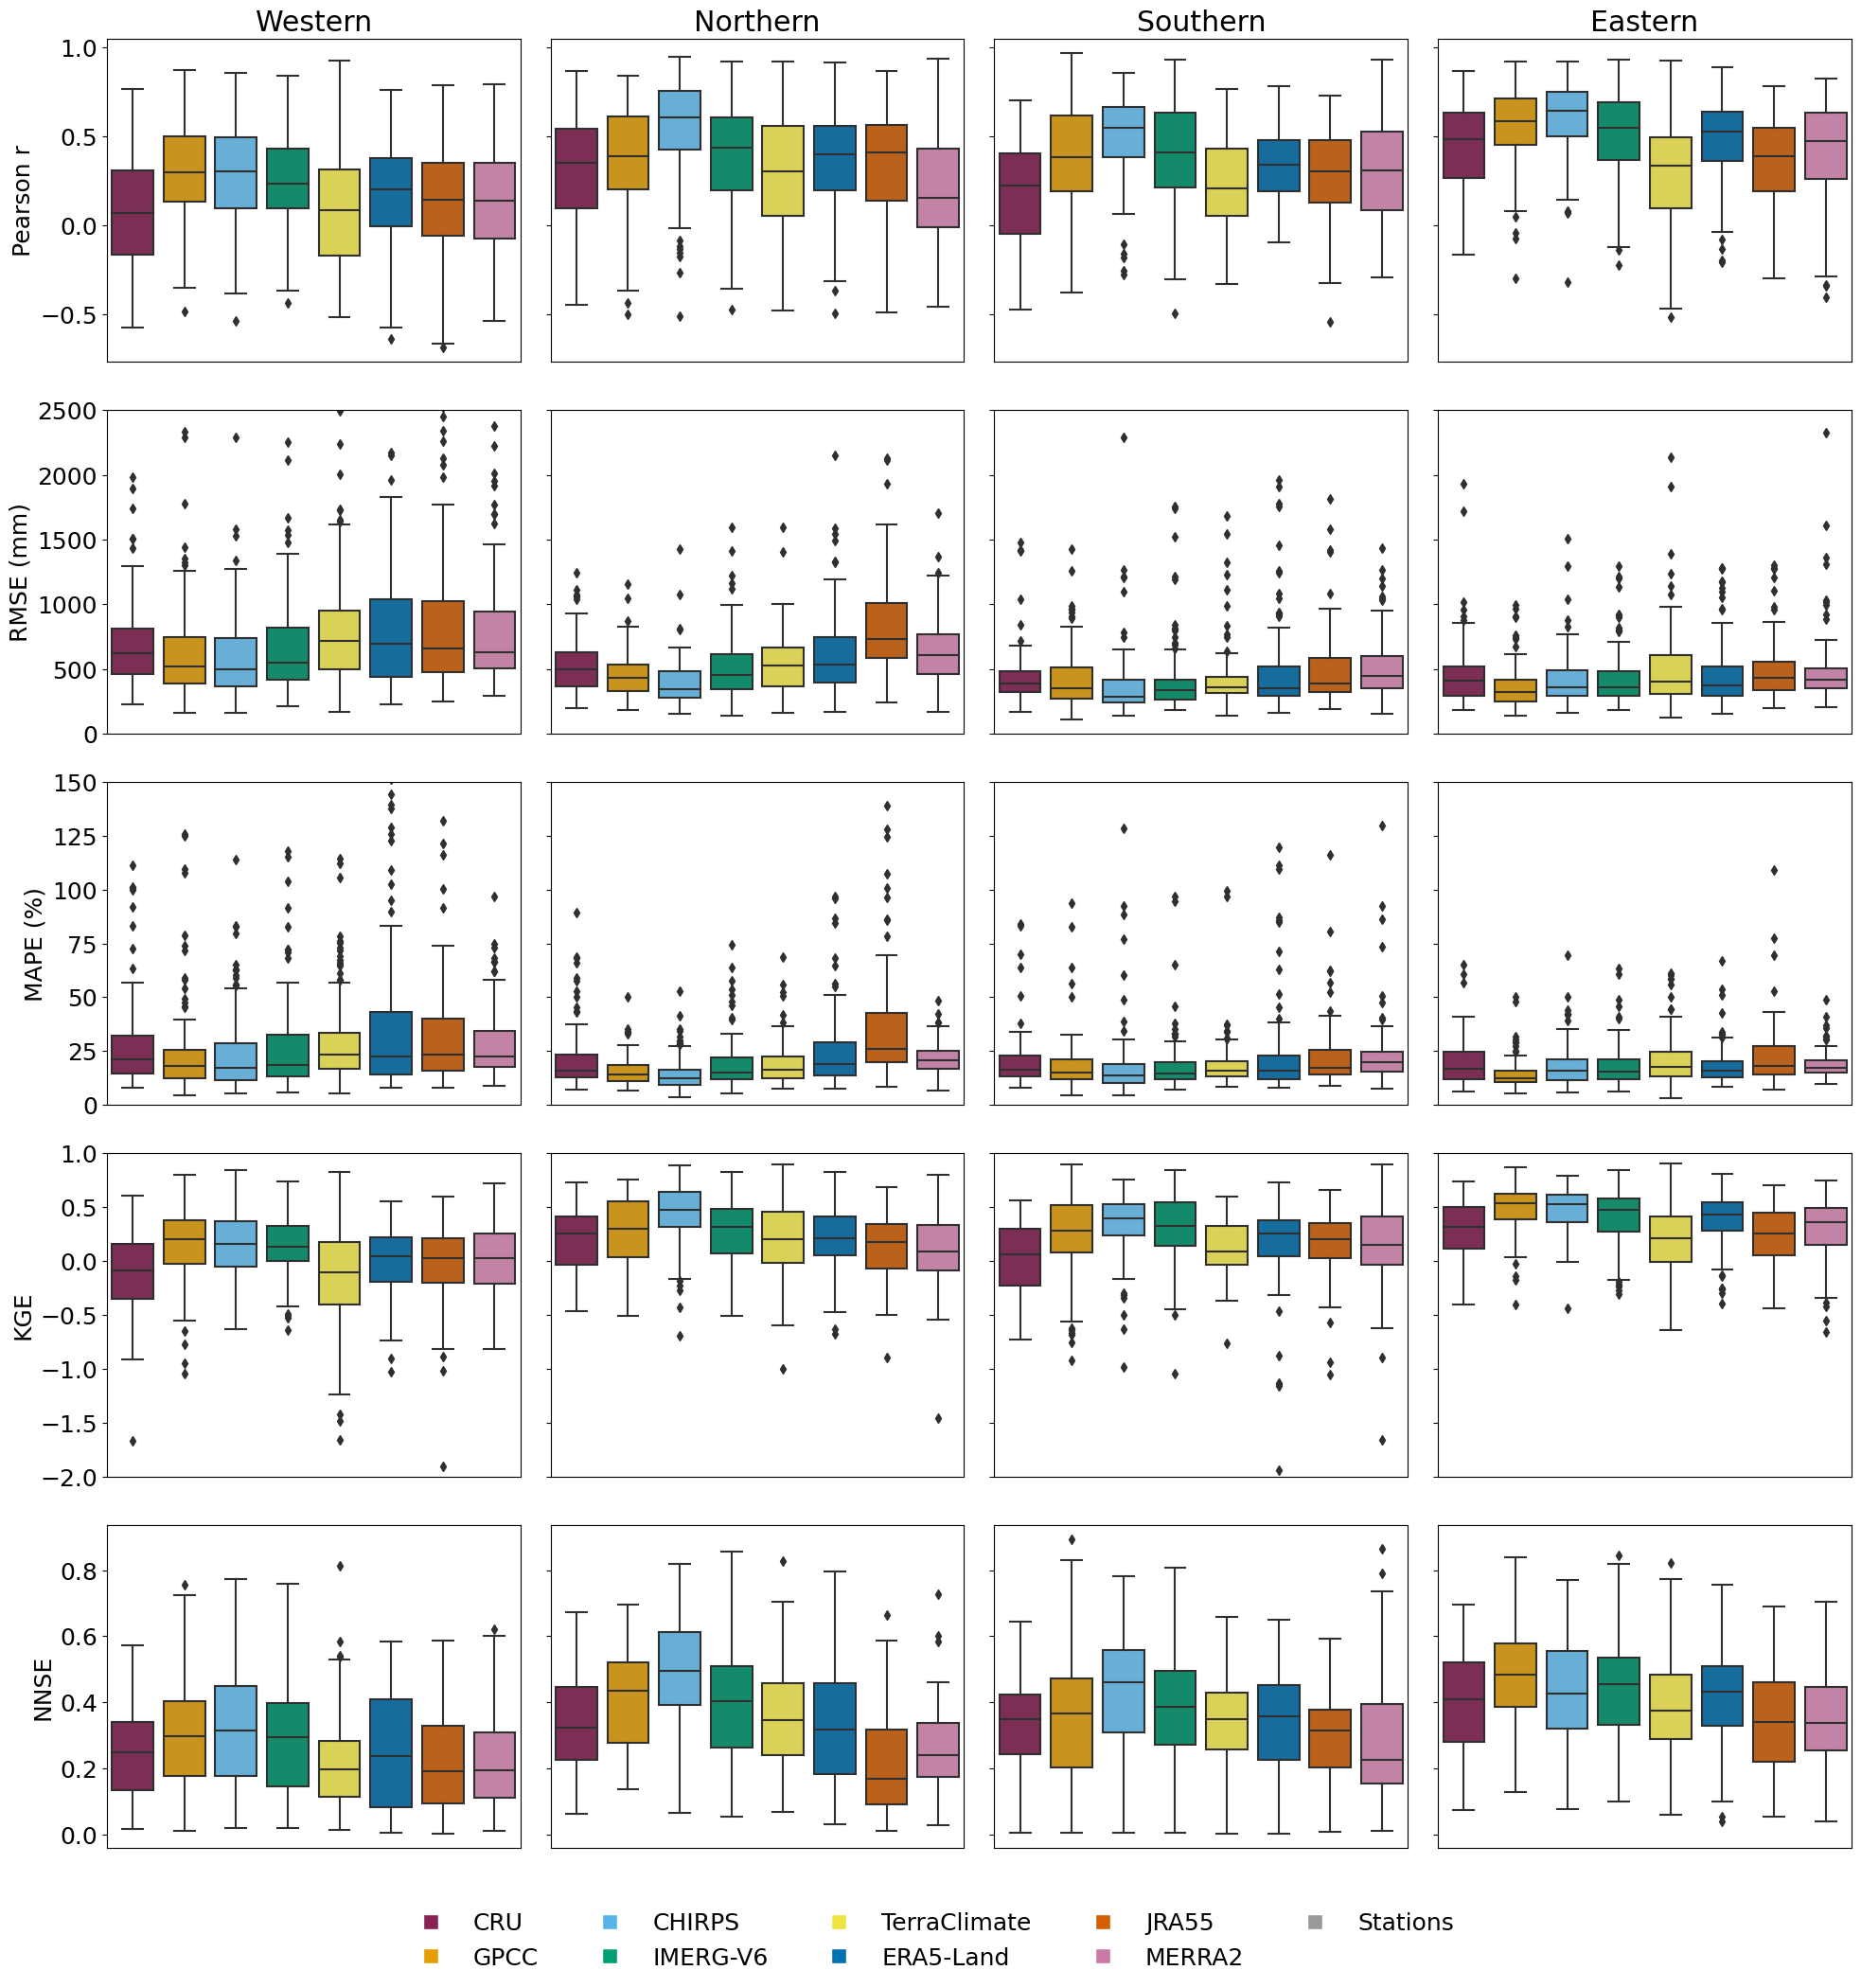

In [15]:
df_metrics['nnse'] = 1/(2-df_metrics['nse'])
metrics_plot = ['corr','rmse', 'mape', 'kge','nnse']
metrics_label = ['Pearson r', 'RMSE (mm)', 'MAPE (%)', 'KGE', 'NNSE']

fig, axes = plt.subplots(len(metrics_plot), 4, figsize = (20, 20), sharey='row')
for i, metric in enumerate(metrics_plot):
    for j, region in enumerate(regions_list):
        #box plot
        df_region = df_metrics[df_metrics.Region == region]
        sns.boxplot( y=metric, data=df_region, ax=axes[i,j], hue_order=hue_order, palette=wong, hue='Dataset',x='Dataset',dodge=False).get_legend().remove()
        #axes[i,j].set_title(region)
        axes[i,j].set_xlabel('')
        axes[i,j].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
        if j == 0:
            axes[i,j].set_ylabel(metrics_label[i])
        else:
            axes[i,j].set_ylabel('')
        if i == 0:
            axes[i,j].set_title(region)

axes[1,0].set_ylim(0,2500)
axes[2,0].set_ylim(0,150)
axes[3,0].set_ylim(-2,1)
fig.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.06), loc='lower center', ncol=5, frameon=False, fontsize=18)

plt.tight_layout()

In [7]:
df_metrics.groupby(['Region', 'Dataset']).mean()

lat        lon      corr        rmse         mae  \
Region   Dataset                                                                
Eastern  CHIRPS        -3.563776 -49.638605  0.598621  416.299385  344.710437   
         CRU           -3.717742 -49.822581  0.441845  454.419918  385.663331   
         ERA5-Land     -3.670513 -49.507693  0.487584  444.065775  373.468650   
         GPCC          -3.778000 -49.846000  0.564772  360.085234  287.254960   
         IMERG-V6      -3.599057 -49.529245  0.505801  416.357922  343.047052   
         JRA55         -3.972864 -49.939786  0.354821  501.057099  427.502242   
         MERRA2        -4.179825 -49.945175  0.416543  484.420044  396.915649   
         TerraClimate  -3.621765 -49.486154  0.297699  486.662528  405.880385   
Northern CHIRPS         0.682692 -63.492788  0.551882  393.244859  320.709288   
         CRU            0.539157 -63.388554  0.317258  547.756888  460.706023   
         ERA5-Land      0.787273 -63.597273  0.382437  617.245862  538.747200   
         GPCC           0.539157 -63.388554  0.364562  455.808010  365.761709   
         IMERG-V6       0.713636 -63.649091  0.400166  502.548306  417.131032   
         JRA55          0.422908 -62.775942  0.335939  860.863323  779.609595   
         MERRA2         0.500000 -63.177711  0.201804  651.766706  545.163290   
         TerraClimate   0.738258 -63.625000  0.294449  539.733835  440.424311   
Southern CHIRPS       -10.897727 -60.515496  0.490481  391.048447  331.142876   
         CRU          -10.829439 -60.950935  0.190969  458.323708  388.576405   
         ERA5-Land    -11.083721 -60.668218  0.334331  475.516185  411.615046   
         GPCC         -10.814220 -60.855505  0.364419  450.134581  363.901762   
         IMERG-V6     -11.069084 -60.664504  0.405952  401.966827  334.772715   
         JRA55        -10.676214 -60.414247  0.283965  509.307089  442.091670   
         MERRA2       -10.593137 -60.784314  0.314192  538.168097  454.475658   
         TerraClimate -11.070252 -60.605136  0.229035  416.470608  345.816840   
Western  CHIRPS        -3.851667 -71.155000  0.279230  586.852919  498.428401   
         CRU           -4.133065 -69.967742  0.065137  691.393775  593.314533   
         ERA5-Land     -3.627976 -71.545833  0.174252  818.233767  734.847241   
         GPCC          -4.133065 -69.967742  0.295667  624.716240  522.850061   
         IMERG-V6      -3.504878 -71.613415  0.249456  691.971667  602.148220   
         JRA55         -4.325432 -70.004849  0.129757  836.393790  751.297442   
         MERRA2        -4.175439 -70.126096  0.141265  809.230867  713.190543   
         TerraClimate  -3.508690 -71.652738  0.076201  788.474089  664.964620   

                            mape       kge        nse      pbias  
Region   Dataset                                                  
Eastern  CHIRPS        18.020734  0.480502  -0.863172  -9.883032  
         CRU           19.998934  0.291797  -1.269904  -8.026804  
         ERA5-Land     17.952709  0.396231  -1.053435   2.204478  
         GPCC          14.317282  0.483304  -0.367596  -0.498425  
         IMERG-V6      17.618486  0.410169  -0.764369  -6.991799  
         JRA55         22.226219  0.237777  -1.842463  -6.447232  
         MERRA2        18.735435  0.301365  -1.635661   9.005720  
         TerraClimate  20.526052  0.197175  -1.295348  -6.260439  
Northern CHIRPS        14.651147  0.432156  -0.452224  -4.508322  
         CRU           22.142323  0.201634  -1.875469  -5.960359  
         ERA5-Land     24.810077  0.225455  -2.842555 -11.038226  
         GPCC          16.062687  0.275231  -0.958392   0.660689  
         IMERG-V6      18.986254  0.281176  -1.325323  -4.872248  
         JRA55         37.071750  0.138441  -7.594533 -21.628136  
         MERRA2        21.950798  0.097194  -3.599007  13.150682  
         TerraClimate  19.740446  0.189110  -1.621683  -1.544843  
Southern CHIRPS        19.274614  0.348393  -3.153663  -6.920764  
 

In [8]:
df_metrics_mean = df_metrics.groupby(['Region', 'Dataset']).mean().reset_index()#.set_index('Dataset').groupby('Region')
df_metrics_mean = df_metrics_mean.set_index('Dataset').groupby('Region')
#get a table with the best dataset for each metric and region
metrics_min = ['rmse','mae','mape']
metrics_max = ['corr','kge','nse']
df_metrics_best = df_metrics_mean[metrics_max].idxmax()
df_metrics_best[metrics_min] = df_metrics_mean[metrics_min].idxmin() 
df_metrics_best
#df_metrics_mean[['corr','rmse','mae','mape','kge','nse','pbias']].reset_index().set_index('Dataset').groupby('Region').idxmax()

corr     kge     nse    rmse     mae    mape
Region                                                  
Eastern   CHIRPS    GPCC    GPCC    GPCC    GPCC    GPCC
Northern  CHIRPS  CHIRPS  CHIRPS  CHIRPS  CHIRPS  CHIRPS
Southern  CHIRPS  CHIRPS  CHIRPS  CHIRPS  CHIRPS  CHIRPS
Western     GPCC    GPCC  CHIRPS  CHIRPS  CHIRPS  CHIRPS

In [95]:
#merge all metrics_dict_05 in one xarray dataset
_ds = list(metrics_dict_05.values())
_coord = list(metrics_dict_05.keys())
ds_out_05 = xr.concat(objs=_ds, dim=_coord, coords='minimal',compat='override').rename({'concat_dim':'Dataset'})
#create cmap from palette wong
from matplotlib.colors import ListedColormap
cmap = ListedColormap(wong[:-1])
ds_out_05['Dataset'] = [0,1,2,3,4,5,6,8]
#from ds_out_05 create a dataset with the best Dataset for each pixel
ds_out_05.idxmax(dim='Dataset').nse.plot(levels=9, cmap=cmap)


# Tests

## pixel to point


In [8]:
df_stat = pd.read_csv(r'Data\Datasets\amz\map\stations_ts.csv', index_col=0)
#merge with stations to get the region
df_stat = df_stat.merge(stations[['Code','geometry']], on='Code')
df_stat = df_stat.rename(columns={'Total':'pr', 'Region':'region', 'Date':'year'})
stations = gpd.read_file(r'Data\Datasets\amz\map\stations.geojson')
regions = gpd.read_file(r'Data\shapefiles\ANA_amz.geojson', driver='GeoJSON')

In [9]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
#import pearson r
from scipy.stats import pearsonr

In [10]:
name = 'CRU'
ds = ds_dict[name]

In [11]:
df_metrics2 = pd.DataFrame()
for i, name in enumerate(datasets_names):
    ds = ds_dict[name]
    stations_data = stations[['Code','geometry']].copy()
    stations_data['lon'] = stations_data['geometry'].apply(lambda p: p.x)
    stations_data['lat'] = stations_data['geometry'].apply(lambda p: p.y)
    stations_data = stations_data.drop(columns=['geometry'])
    #stations_data['data_value'] = np.nan
    # Step 2: Select the value from the DataArray that corresponds to the pixel closest to each station
    for idx, station in stations_data.iterrows():
        lon, lat = station['lon'], station['lat']
        nearest_value = ds.sel(lat=lat, lon=lon, method='nearest')
        stations_data.at[idx, name] = nearest_value.values
        stations_data.at[idx, name] = nearest_value.pr.values

    years = range(2001, 2021)
    data_dict = {year: [value[i] for value in stations_data[name]] for i, year in enumerate(years)}
    data_df = pd.DataFrame(data_dict)
    stations_data = pd.concat([stations_data, data_df], axis=1).drop(columns=[name])
    stations_data_tidy = pd.melt(stations_data, id_vars=['Code','lon', 'lat'], var_name='year', value_name=name)
    stat_ds = stations_data_tidy.merge(df_stat[['Code', 'year','pr']], on=['Code', 'year']).rename(columns={'pr':'station'}).dropna()
    #for each Code, calculate the RMSE
    stats_metric = stat_ds.groupby('Code').apply(lambda x: mean_squared_error(x['station'], x[name], squared=False)).reset_index().rename(columns={0:'rmse'})
    #now the mean absolute error
    stats_metric['mae'] = stat_ds.groupby('Code').apply(lambda x: mean_absolute_error(x['station'], x[name])).reset_index().rename(columns={0:'mae'})['mae']
    #correlation pearson
    stats_metric['corr'] = stat_ds.groupby('Code').apply(lambda x: x['station'].corr(x[name])).reset_index().rename(columns={0:'corr'})['corr']
    #MAPE
    stats_metric['mape'] = stat_ds.groupby('Code').apply(lambda x: mean_absolute_percentage_error(x['station'], x[name])).reset_index().rename(columns={0:'mape'})['mape']
    stats_metric = stats_metric.merge(stations[['Code', 'geometry','Region']], on='Code')
    stats_metric['dataset'] = name
    df_metrics2 = df_metrics2.append(stats_metric)


C:\Users\luisg\AppData\Local\Temp\ipykernel_8268\2033980638.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics2 = df_metrics2.append(stats_metric)
C:\Users\luisg\AppData\Local\Temp\ipykernel_8268\2033980638.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics2 = df_metrics2.append(stats_metric)
C:\Users\luisg\AppData\Local\Temp\ipykernel_8268\2033980638.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics2 = df_metrics2.append(stats_metric)
C:\Users\luisg\AppData\Local\Temp\ipykernel_8268\2033980638.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics2 = df_metrics2.append(stats_metric)
C:\U

In [ ]:

#df_metrics to gdf_metrics
gdf_metrics2 = gpd.GeoDataFrame(df_metrics2, geometry='geometry', crs='EPSG:4326')

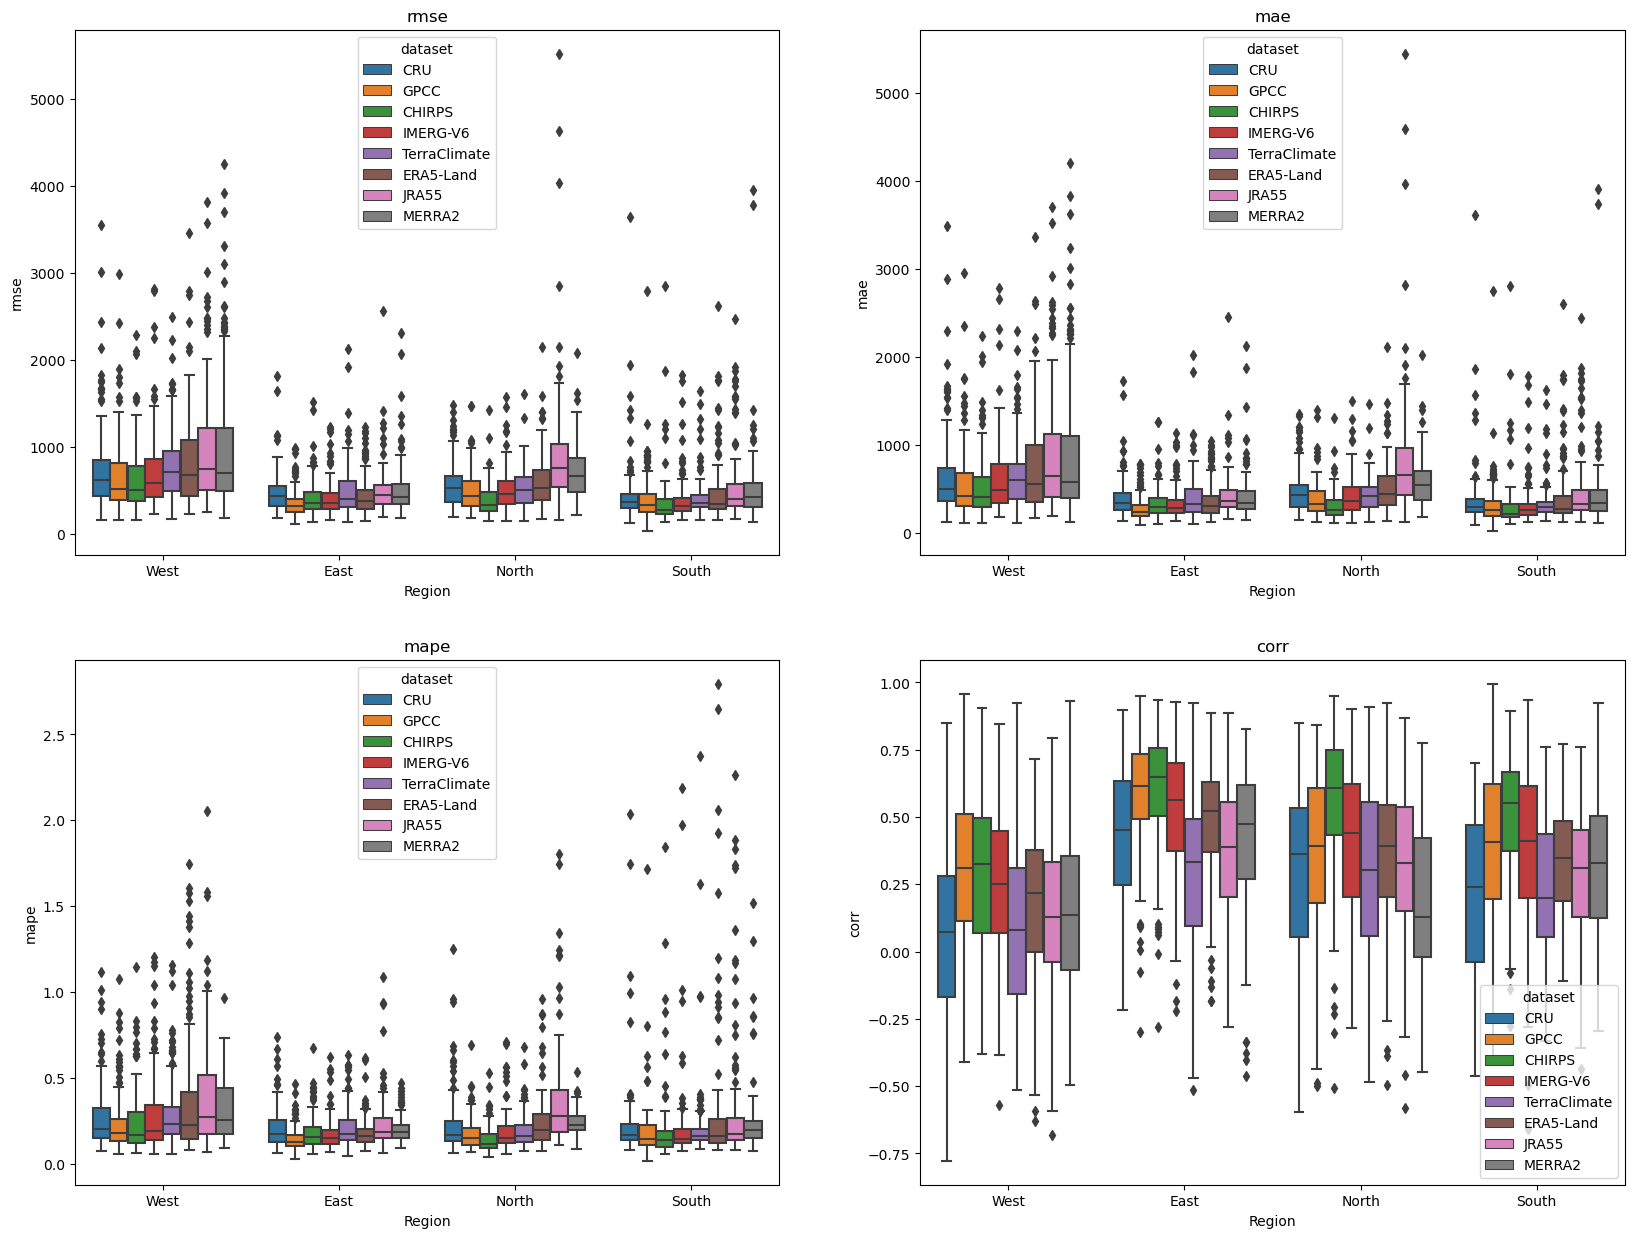

In [ ]:
metrics = ['rmse','mae', 'mape','corr']
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
# boxplot for each metric
for metric, ax in zip(metrics, axes.flatten()):
    sns.boxplot(data=df_metrics2, x='Region', y=metric, hue='dataset', ax=ax)
    ax.set_title(metric)


C:\Users\luisg\AppData\Local\Temp\ipykernel_20540\1307484876.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


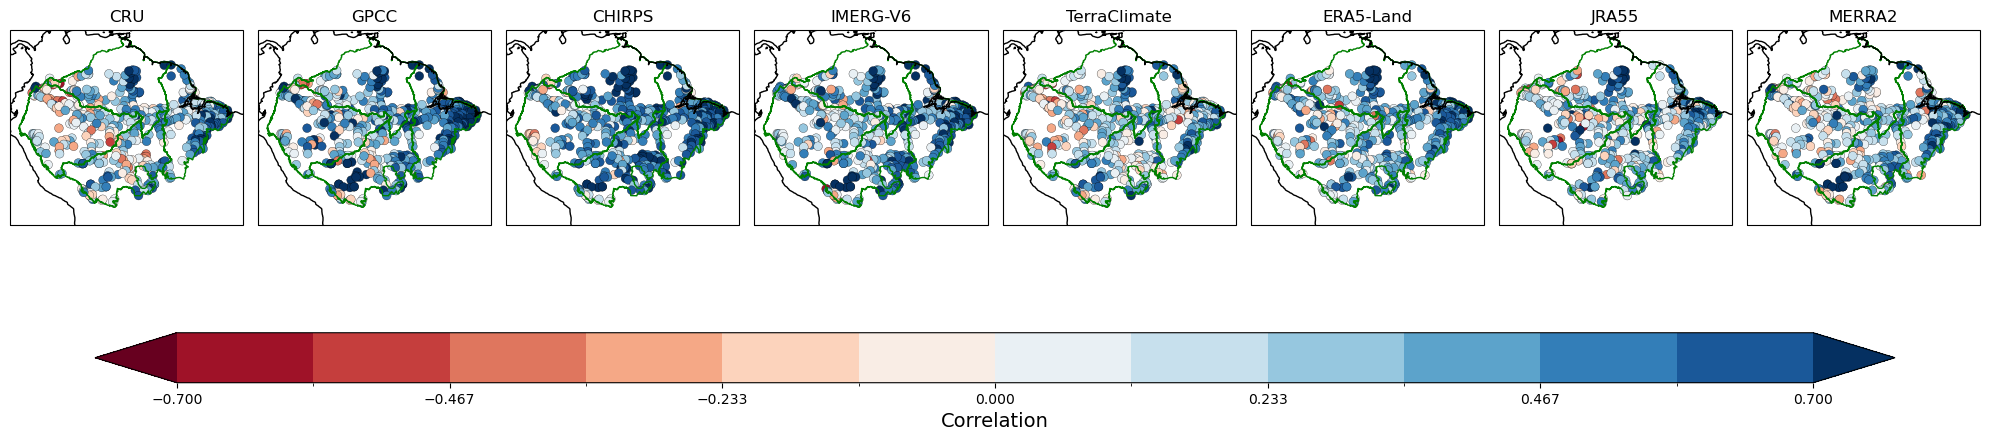

In [ ]:
vmin = -0.7
vmax = 0.7
levels = 13
proj = ccrs.Mercator()
extend = [-81, -42, -20, 11]
extend_cmap = 'both'
cmap = 'RdBu'
stat_bins = np.linspace(vmin,vmax, levels)
# Create a figure and a gridspec layout
fig , axes = plt.subplots(1, len(datasets), figsize=(20, 5), subplot_kw={'projection': proj})

# Loop through the datasets and plot them
for i, name in enumerate(datasets_names):
    # Create an axis for the subplot
    ax = axes[i]
    df = gdf_metrics2[df_metrics2['dataset'] == name]
    ax.add_geometries(regions.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='green', linewidth=1)

    # Plot the data
    df.to_crs(proj).plot(ax=ax, column='corr', cmap=cmap,   scheme="User_Defined", 
                classification_kwds=dict(bins=stat_bins), linewidth=0.2, edgecolor='black', markersize=40)
    
    # Add a title for each subplot
    ax.set_title(datasets_names[i])
    # Remove x and y labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_extent([-81, -42, -20, 11])
    ax.coastlines()


#plot amz
# Add a colorbar
cax = fig.add_axes([0.05, -0.01, 0.9, 0.1])
cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
cbar.set_label('Correlation', fontsize=14)

plt.tight_layout()


In [ ]:
vmin = -0.7
vmax = 0.7
levels = 13
proj = ccrs.Mercator()
extend = [-81, -42, -20, 11]
extend_cmap = 'both'
cmap = 'RdBu'
stat_bins = np.linspace(vmin,vmax, levels)
# Create a figure and a gridspec layout
fig , axes = plt.subplots(1, len(datasets), figsize=(20, 5), subplot_kw={'projection': proj})

# Loop through the datasets and plot them
for i, name in enumerate(datasets_names):
    # Create an axis for the subplot
    ax = axes[i]
    df = gdf_metrics2[df_metrics2['dataset'] == name]
    ax.add_geometries(regions.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='green', linewidth=1)

    # Plot the data
    df.to_crs(proj).plot(ax=ax, column='corr', cmap=cmap,   scheme="User_Defined", 
                classification_kwds=dict(bins=stat_bins), linewidth=0.2, edgecolor='black', markersize=40)
    
    # Add a title for each subplot
    ax.set_title(datasets_names[i])
    # Remove x and y labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_extent([-81, -42, -20, 11])
    ax.coastlines()


#plot amz
# Add a colorbar
cax = fig.add_axes([0.05, -0.01, 0.9, 0.1])
cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
cbar.set_label('Correlation', fontsize=14)

plt.tight_layout()
